# Dataset Analysis with Configurable Train / Val / Test Split

In [313]:
# ------------------------------------------------------------
# CONFIG – edit only the variables below
# ------------------------------------------------------------
# → TRAIN_DATASETS and TEST_DATASETS are *explicit* lists.
#   Any dataset name **not** appearing in either list will be
#   discarded if DROP_OTHER_DATASETS = True (recommended).
# ------------------------------------------------------------
TRAIN_DATASETS      = ['camcan', 'dallas_lifespan', 'npc', 'nimh_rv', 'oasis3']  # example
TEST_DATASETS       = ['ixi', 'boldvar']                    # example

VAL_FRACTION        = 0.10   # 0.10 → 10 % of the final TRAIN → VAL
RANDOM_STATE        = 42     # to make the split reproducible
DROP_OTHER_DATASETS = True   # ignore rows from datasets not listed above

# --- global analysis parameters (unchanged) -------------------------------
AGE_MIN, AGE_MAX = 18, 85
MODALITIES       = ['t1', 't2', 'flair']

In [314]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import itertools, warnings, uuid, sys
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', context='notebook')

In [315]:
# ------------------------------------------------------------
# Helper functions (unchanged)
# ------------------------------------------------------------
def clean_df(raw: pd.DataFrame) -> pd.DataFrame:
    """Standardise column names & values, drop unusable rows."""
    df = raw.copy()
    df.columns = df.columns.str.strip().str.lower()

    df['age'] = pd.to_numeric(df['age'], errors='coerce').round()
    df['sex'] = (df['sex'].astype(str).str.lower().str.strip()
                   .map({'m':'male','male':'male','1':'male',
                        'f':'female','female':'female','2':'female'}))
    df['modality'] = (df['modality'].astype(str).str.lower()
                        .str.extract('(t1|t2|flair)', expand=False))

    df = (df.dropna(subset=['age','sex','modality'])
            .query('@AGE_MIN <= age <= @AGE_MAX'))
    df['age'] = df['age'].astype(int)
    return df

def coverage_report(df: pd.DataFrame, title: str = ''):
    all_combos  = set(itertools.product(range(AGE_MIN, AGE_MAX+1),
                                        ['male','female'], MODALITIES))
    present     = set(zip(df['age'], df['sex'], df['modality']))
    missing     = sorted(all_combos - present)

    print(f'=== {title or "Dataset"} ===')
    print(f'Expected combinations : {len(all_combos)}')
    print(f'Observed combinations : {len(present)}')
    print(f'Missing combinations  : {len(missing)}\n')

    if missing:
        display(pd.DataFrame(missing, columns=['age','sex','modality']))

    subset = (df.groupby(['age','sex','modality'], group_keys=False)
                .sample(n=1, random_state=42)
                .reset_index(drop=True))
    return subset

def quick_plots(df: pd.DataFrame, title: str = ''):
    print(f'\n### {title} – shape: {df.shape}\n')
    display(df.head())

    fig, axes = plt.subplots(1, 3, figsize=(18,4))
    sns.countplot(x='modality', data=df, ax=axes[0]); axes[0].set_title('Modality')
    sns.countplot(x='sex',      data=df, ax=axes[1]); axes[1].set_title('Sex')
    sns.histplot(df['age'], bins=20, kde=True, ax=axes[2]); axes[2].set_title('Age')
    plt.suptitle(title); plt.tight_layout(); plt.show()

    # distribution per dataset for richer insight
    for col in ['modality', 'sex']:
        g = sns.catplot(data=df, x=col, col='dataset', kind='count', col_wrap=4, sharey=False)
        g.fig.suptitle(f'{col.capitalize()} distribution per dataset', y=1.02)
        plt.show()

    g = sns.displot(data=df, x='age', col='dataset', bins=20, col_wrap=4, kde=True)
    g.fig.suptitle('Age distribution per dataset', y=1.02)
    plt.show()

In [316]:
# ------------------------------------------------------------
# Load Excel and concatenate all sheets
# ------------------------------------------------------------
EXCEL_FILE = 'all_datasets.xlsx'  # change path if needed

sheets = pd.read_excel(EXCEL_FILE, sheet_name=None)
df_list = []
for name, sheet in sheets.items():
    if 'dataset' not in sheet.columns or sheet['dataset'].isna().all():
        sheet['dataset'] = name
    df_list.append(sheet)

df_all = pd.concat(df_list, ignore_index=True)
df_all = clean_df(df_all)
print('Loaded & cleaned data →', df_all.shape)

Loaded & cleaned data → (7069, 6)


### Train / Val / Test Split Summary

In [317]:
# ------------------------------------------------------------
# Build explicit TRAIN / VAL / TEST partitions
# ------------------------------------------------------------
train_lower = [d.lower() for d in TRAIN_DATASETS]
test_lower  = [d.lower() for d in TEST_DATASETS]

# sanity checks -------------------------------------------------------------
if set(train_lower) & set(test_lower):
    raise ValueError('A dataset appears in both TRAIN_DATASETS and TEST_DATASETS')

all_datasets_lower = df_all['dataset'].str.lower()

is_train = all_datasets_lower.isin(train_lower)
is_test  = all_datasets_lower.isin(test_lower)

if DROP_OTHER_DATASETS:
    used_mask = is_train | is_test
    dropped   = df_all.loc[~used_mask, 'dataset'].unique()
    if len(dropped):
        print(' ⚠️  Dropping datasets (not in either list):', dropped)
    df_all   = df_all[used_mask].copy()
    is_train = is_train.loc[df_all.index]
    is_test  = is_test .loc[df_all.index]

# ---------------------------------------------------------------------------
# Split the TRAIN part into TRAIN and VAL
# ---------------------------------------------------------------------------
df_train_full = df_all[is_train].copy()
df_test       = df_all[is_test ].copy()

if VAL_FRACTION > 0:
    df_train, df_val = train_test_split(
        df_train_full,
        test_size   = VAL_FRACTION,
        random_state= RANDOM_STATE,
        stratify    = df_train_full[['modality','sex']]  # keep distrib. balanced
    )
else:
    df_train = df_train_full.copy(); df_val = pd.DataFrame(columns=df_all.columns)

print(f'Total rows used : {len(df_all):,}')
print(f'  TRAIN : {len(df_train):,}')
print(f'  VAL   : {len(df_val):,}')
print(f'  TEST  : {len(df_test):,}')

 ⚠️  Dropping datasets (not in either list): ['ixi' 'mpi_leipzig']
Total rows used : 5,055
  TRAIN : 4,266
  VAL   : 475
  TEST  : 314


In [318]:
# ------------------------------------------------------------
# Save split to CSV files
# ------------------------------------------------------------
df_train.to_csv('train.csv', index=False)
df_val  .to_csv('val.csv',   index=False)
df_test .to_csv('test.csv',  index=False)
print('Saved  train.csv | val.csv | test.csv')

Saved  train.csv | val.csv | test.csv


### Train Set Analysis


### TRAIN set – shape: (4266, 6)



,subject_id,image_path,sex,age,modality,dataset
1746,sub-CC220920,/mnt/data/brain_age_preprocessed/CamCAN/sub-CC...,female,34,t2,camcan
4735,sub-20,/mnt/data/brain_age_preprocessed/OpenNeuro/NPC...,male,24,t1,npc
6100,sub-OAS31299,/mnt/data/brain_age_preprocessed/OASIS/OASIS3/...,male,61,flair,oasis3
2246,sub-CC420776,/mnt/data/brain_age_preprocessed/CamCAN/sub-CC...,female,49,t2,camcan
2105,sub-CC410248,/mnt/data/brain_age_preprocessed/CamCAN/sub-CC...,male,54,t1,camcan


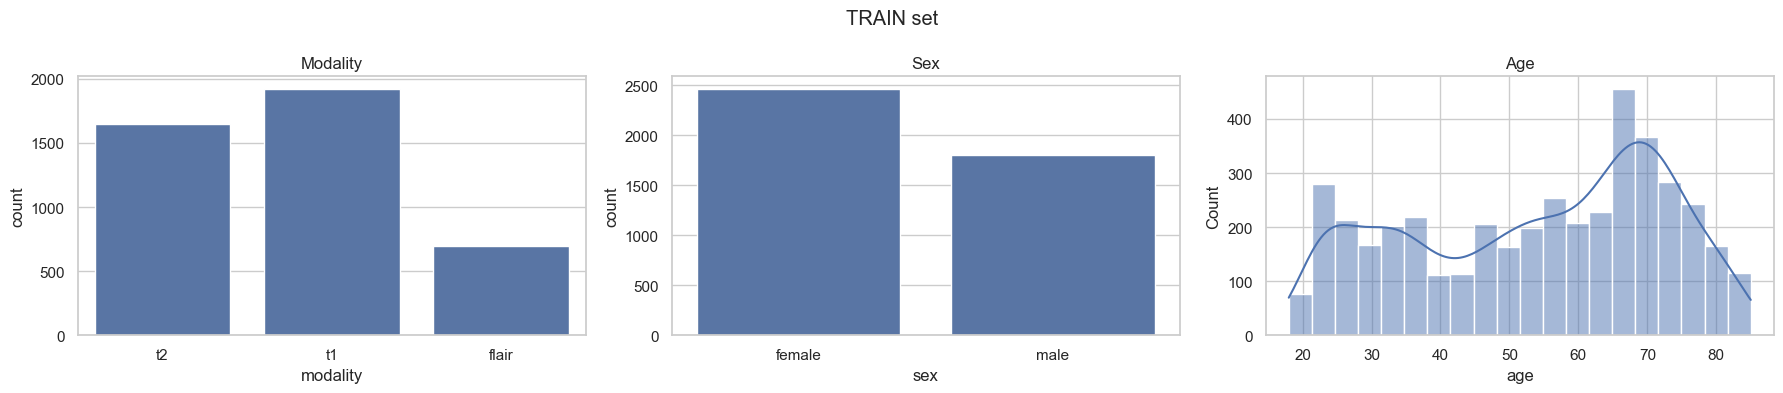

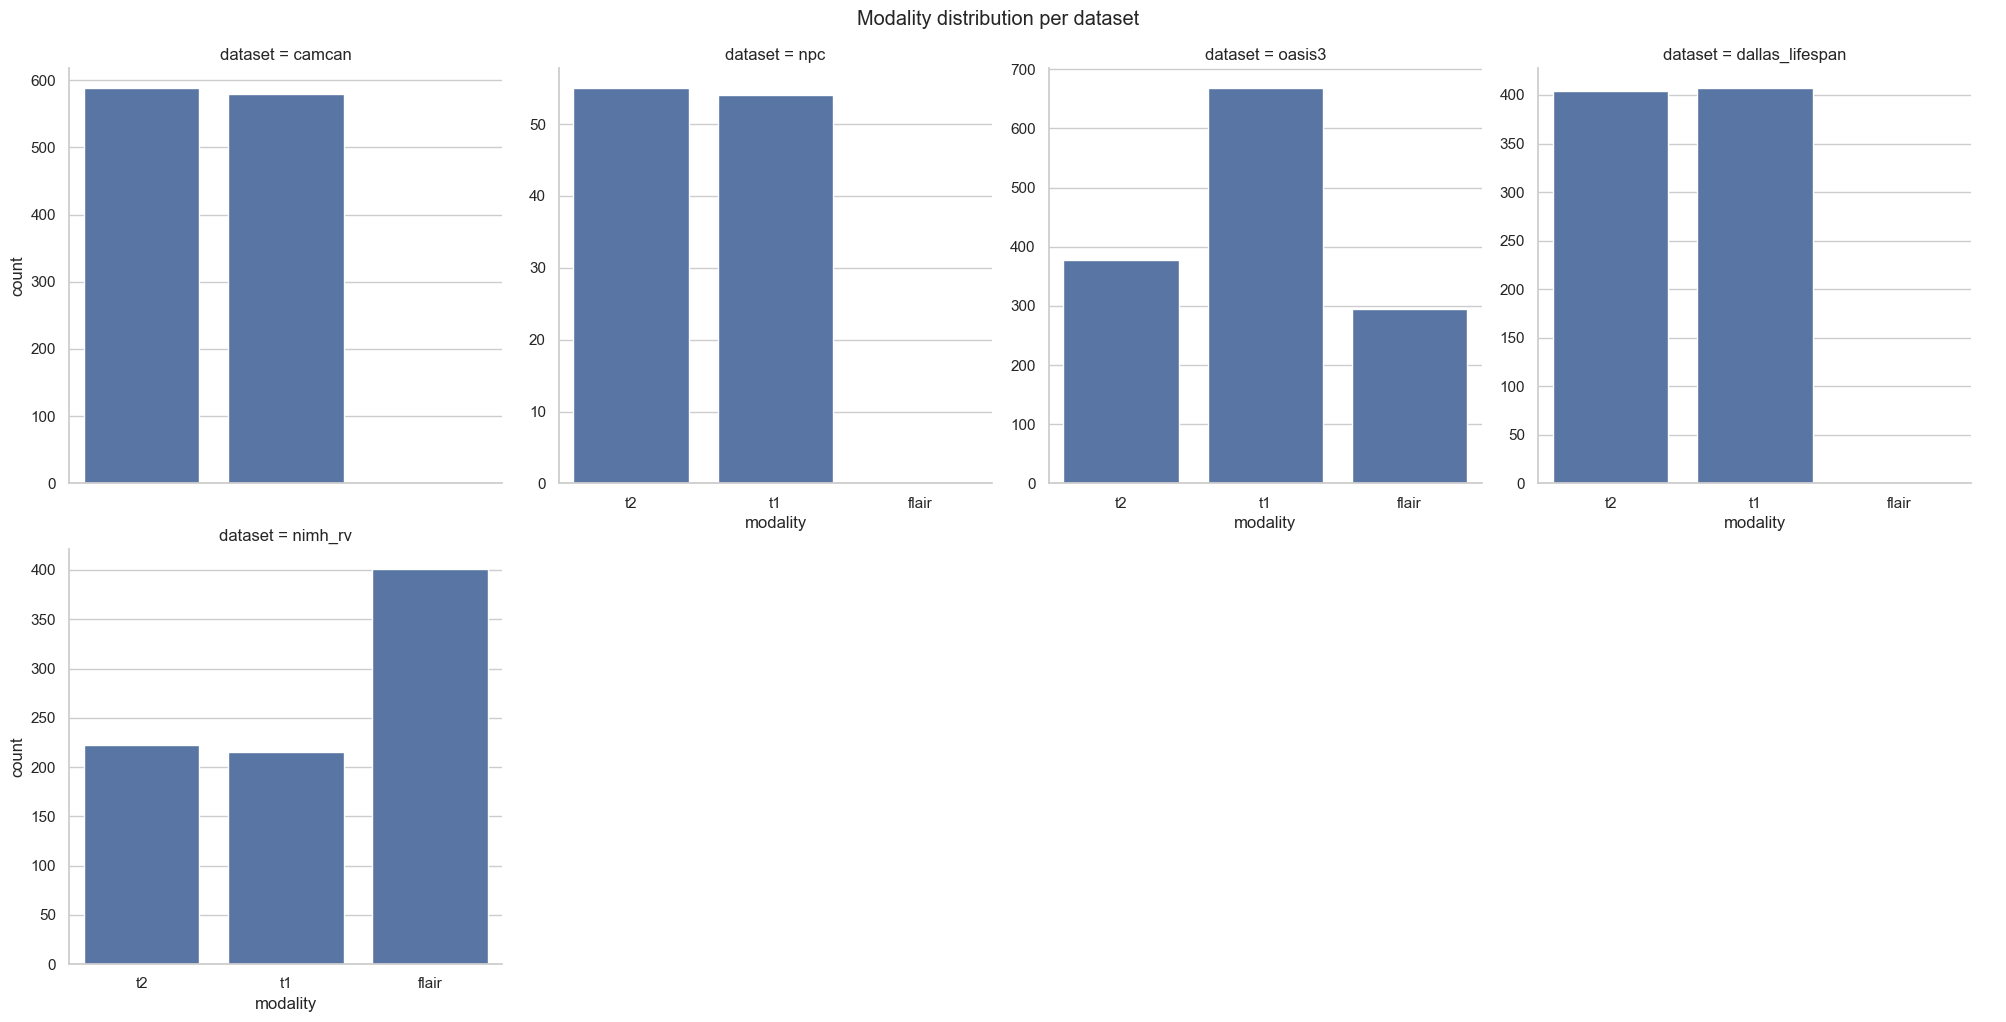

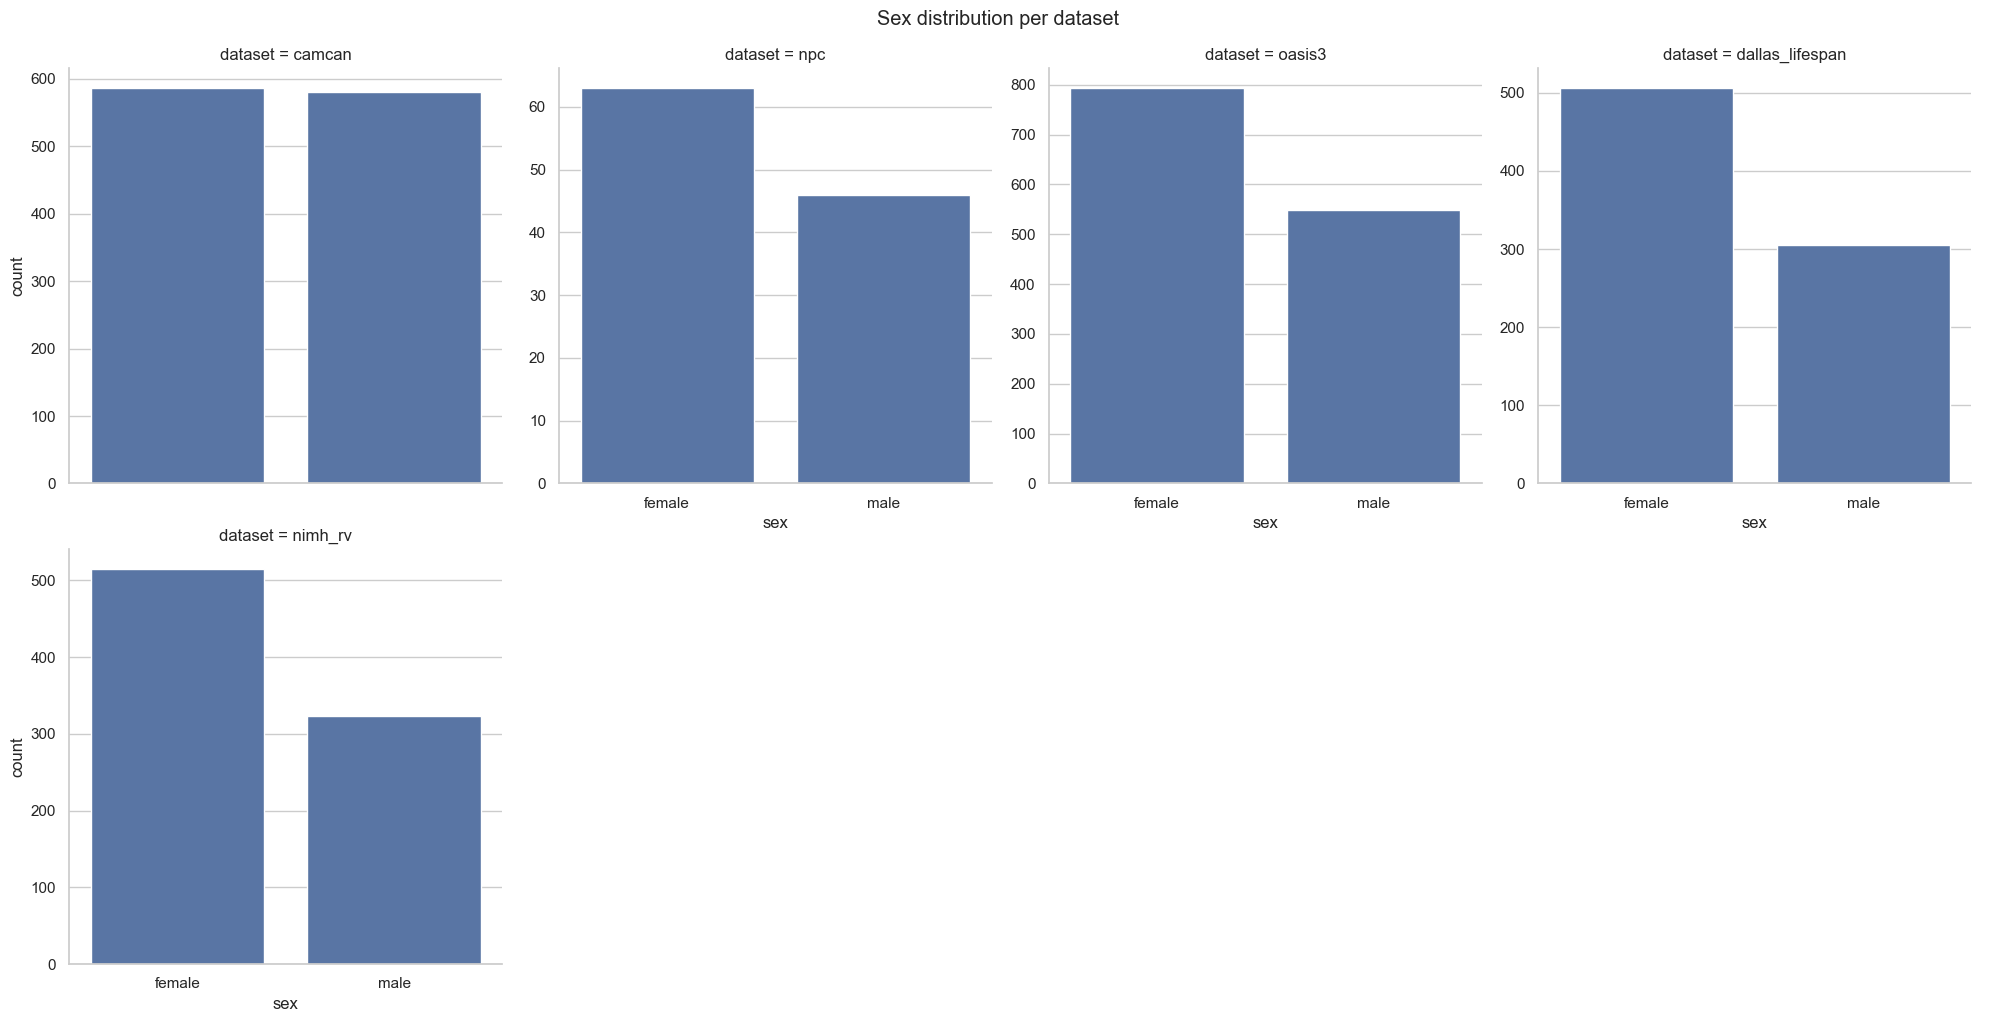

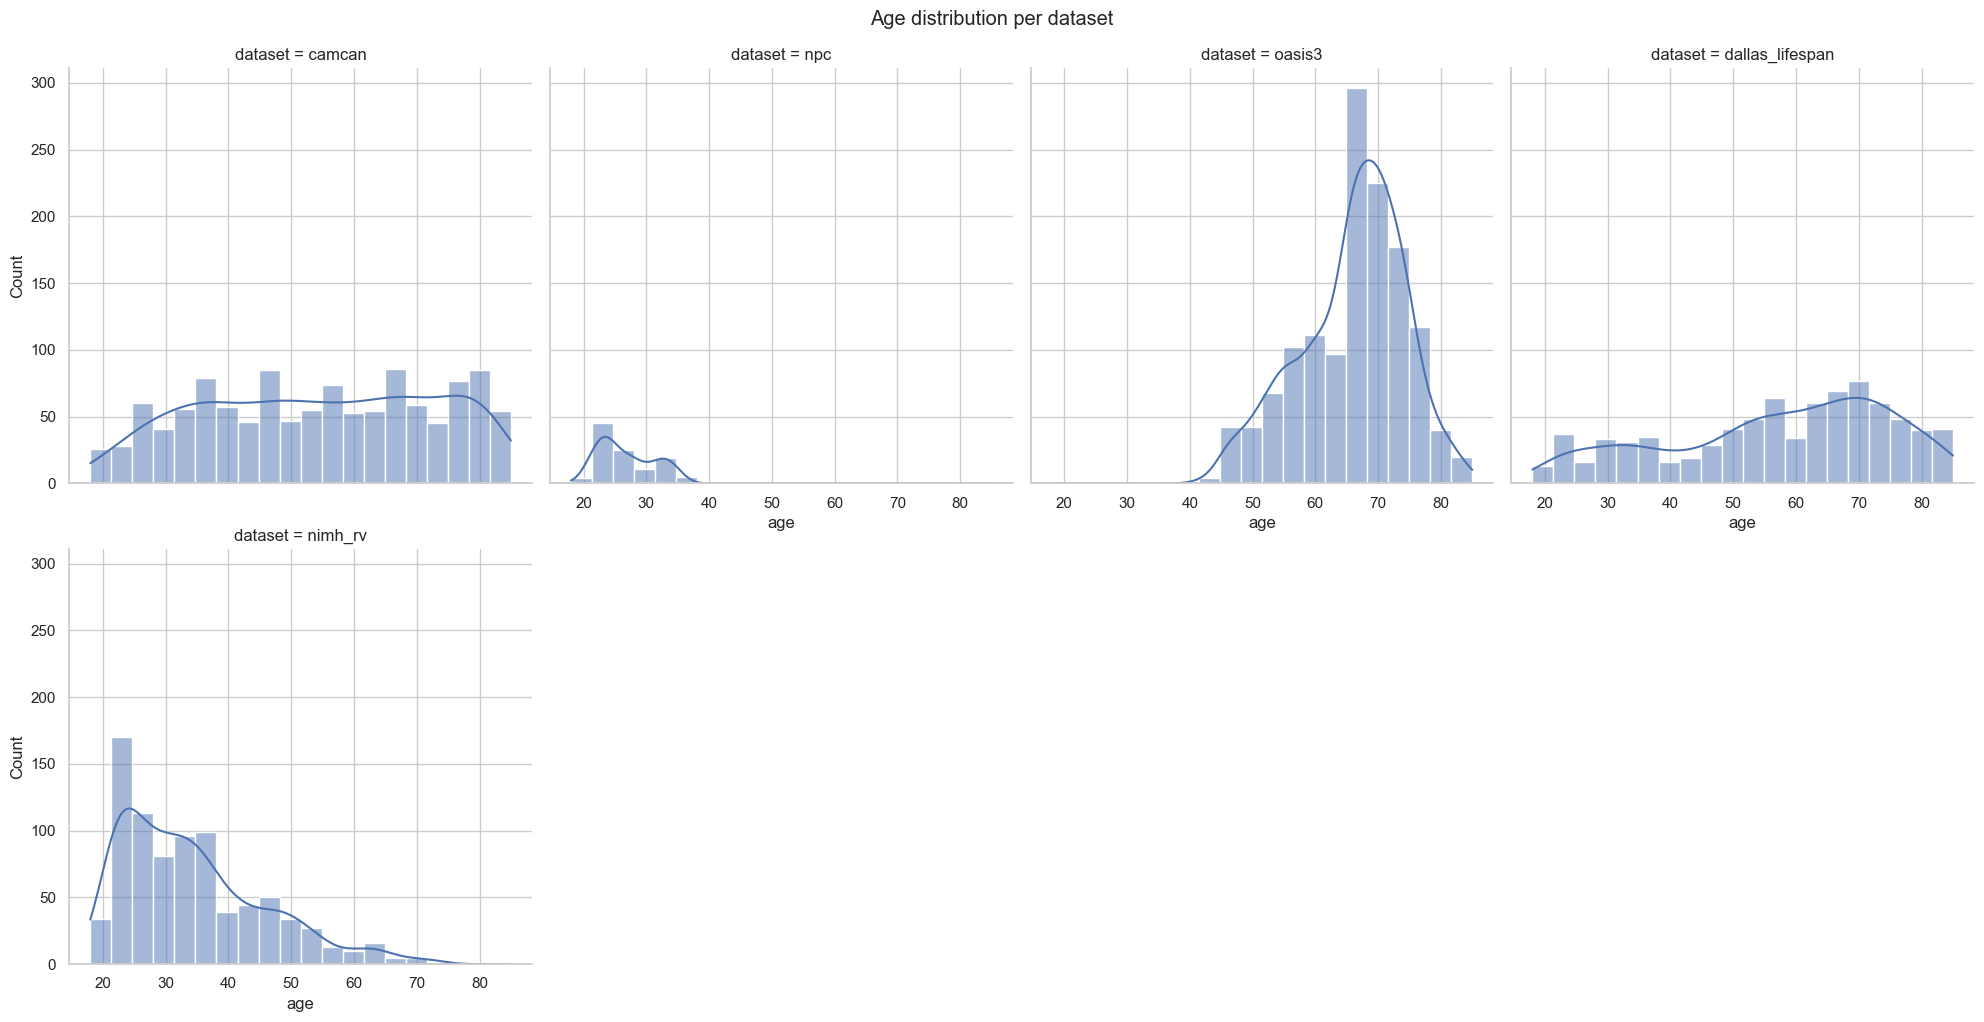

=== TRAIN coverage ===
Expected combinations : 408
Observed combinations : 393
Missing combinations  : 15



,age,sex,modality
0,18,female,flair
1,18,male,flair
2,19,female,flair
3,20,female,flair
4,41,male,flair
5,45,male,flair
6,52,male,flair
7,53,male,flair
8,80,female,flair
9,82,male,flair


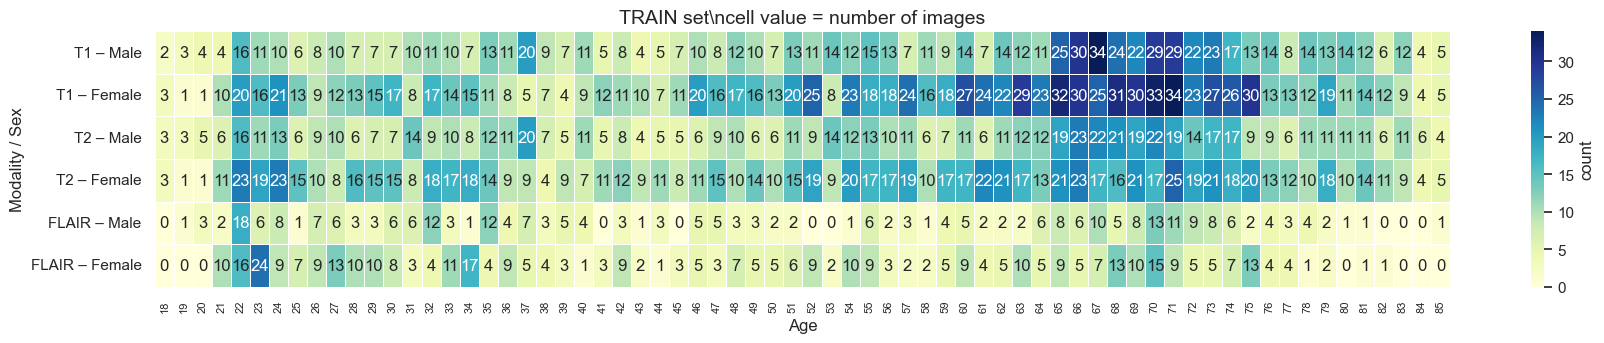

Saved train_one_per_combo.csv


In [319]:
quick_plots(df_train, 'TRAIN set')
train_subset = coverage_report(df_train, 'TRAIN coverage')
train_subset.to_csv('train_one_per_combo.csv', index=False)
plot_count_heatmap(df_train, 'TRAIN set')
print('Saved train_one_per_combo.csv')

### Validation Set Analysis


### VAL set – shape: (475, 6)



,subject_id,image_path,sex,age,modality,dataset
3579,sub-532,/mnt/data/brain_age_preprocessed/OpenNeuro/Dal...,male,64,t1,dallas_lifespan
2468,sub-CC610061,/mnt/data/brain_age_preprocessed/CamCAN/sub-CC...,female,76,t2,camcan
5798,sub-OAS31047,/mnt/data/brain_age_preprocessed/OASIS/OASIS3/...,female,67,t1,oasis3
5594,sub-OAS30788,/mnt/data/brain_age_preprocessed/OASIS/OASIS3/...,female,75,t1,oasis3
4455,sub-ON89474,/mnt/data/brain_age_preprocessed/NIMH_RV/sub-O...,female,36,t1,nimh_rv


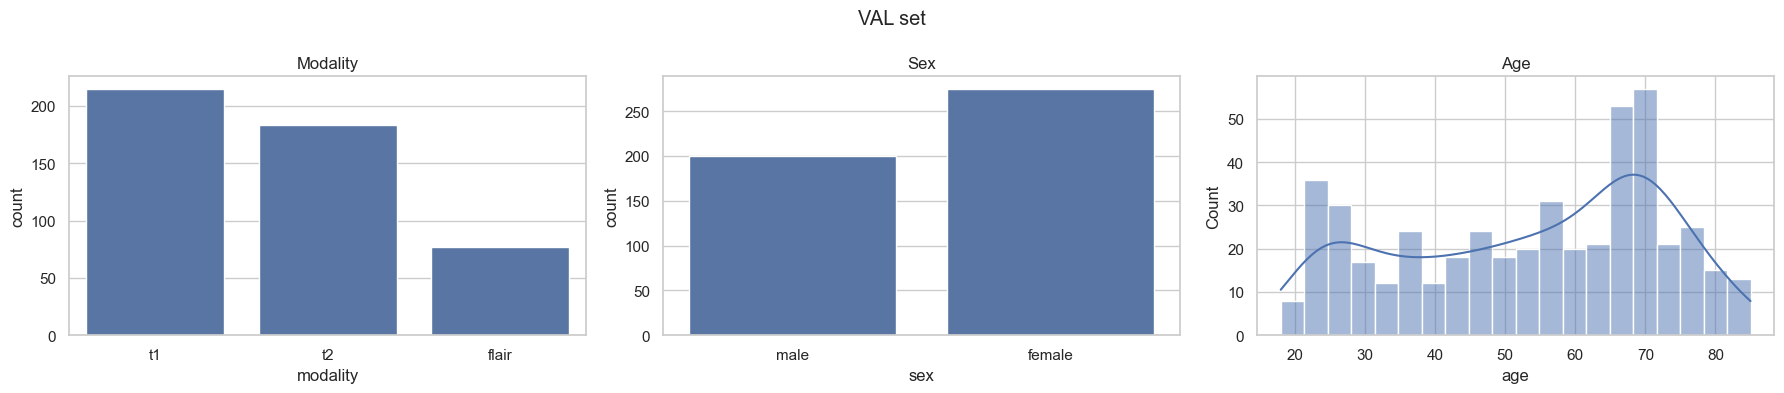

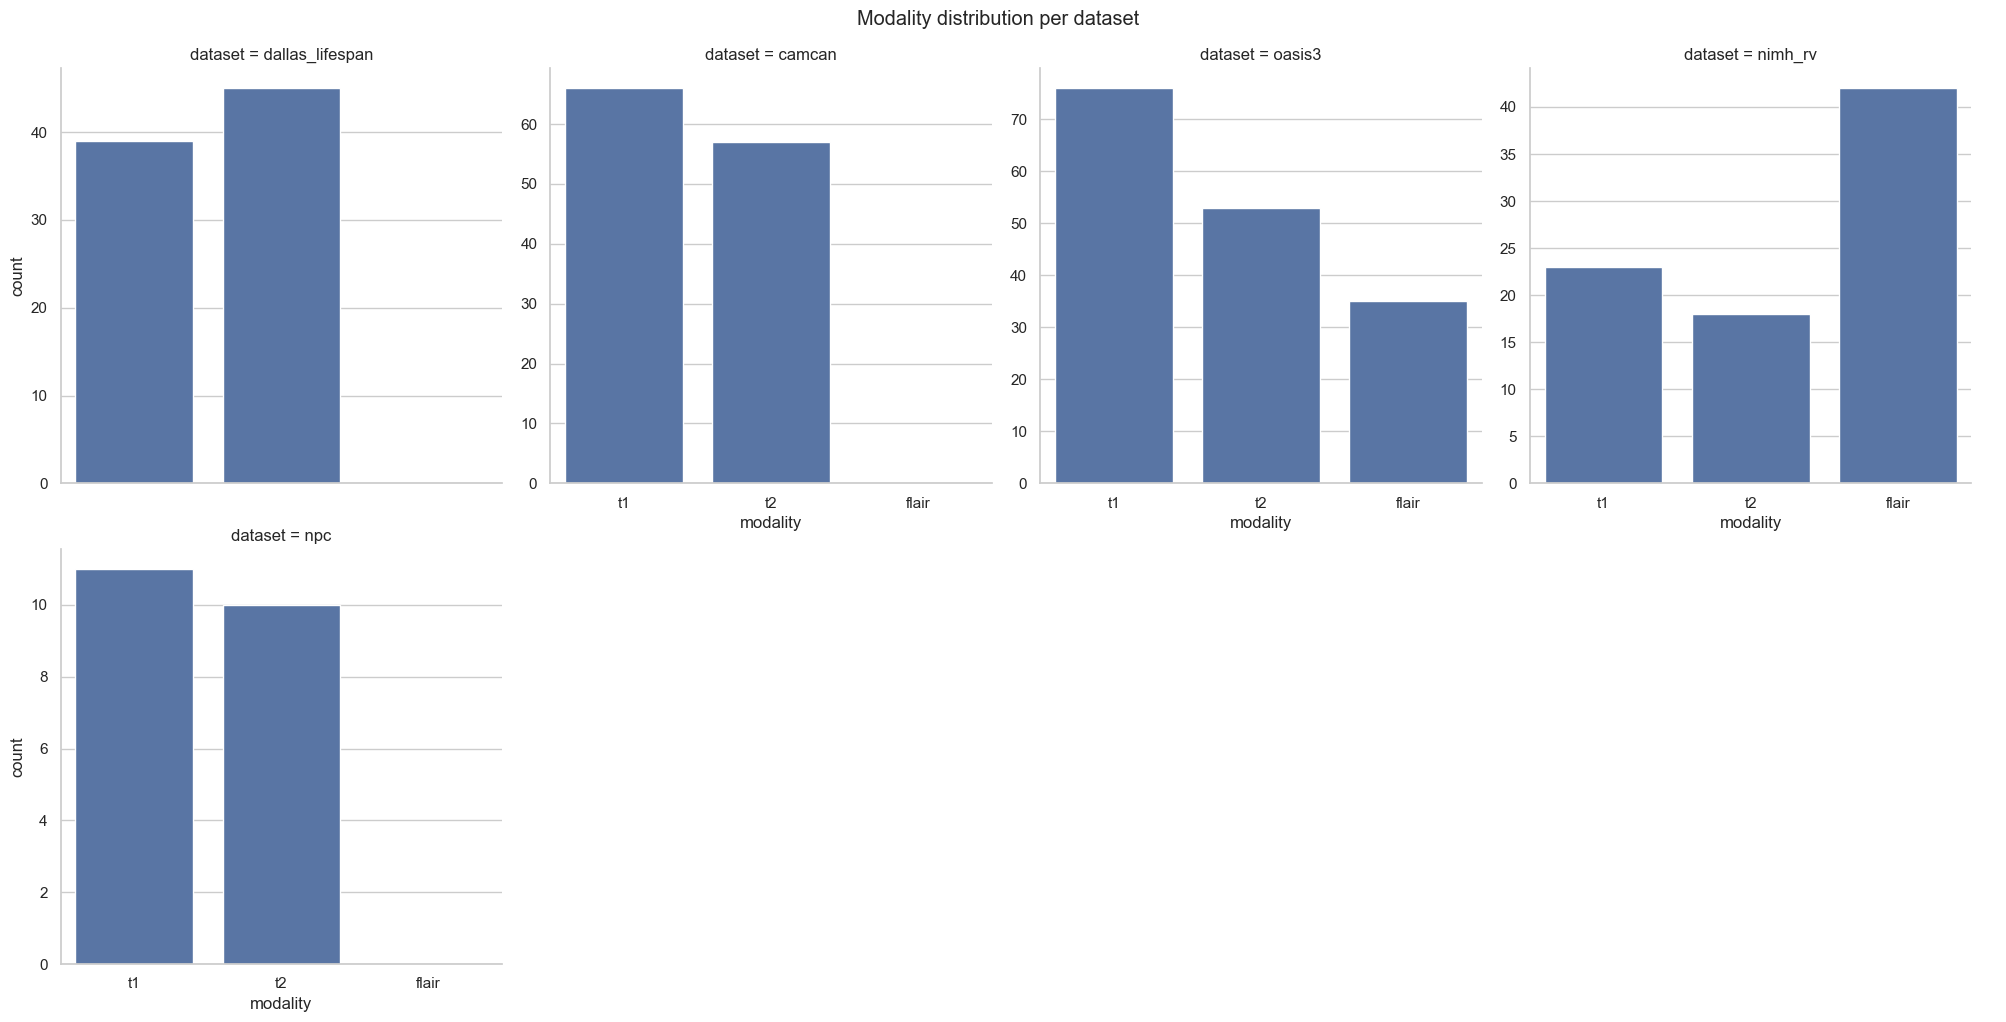

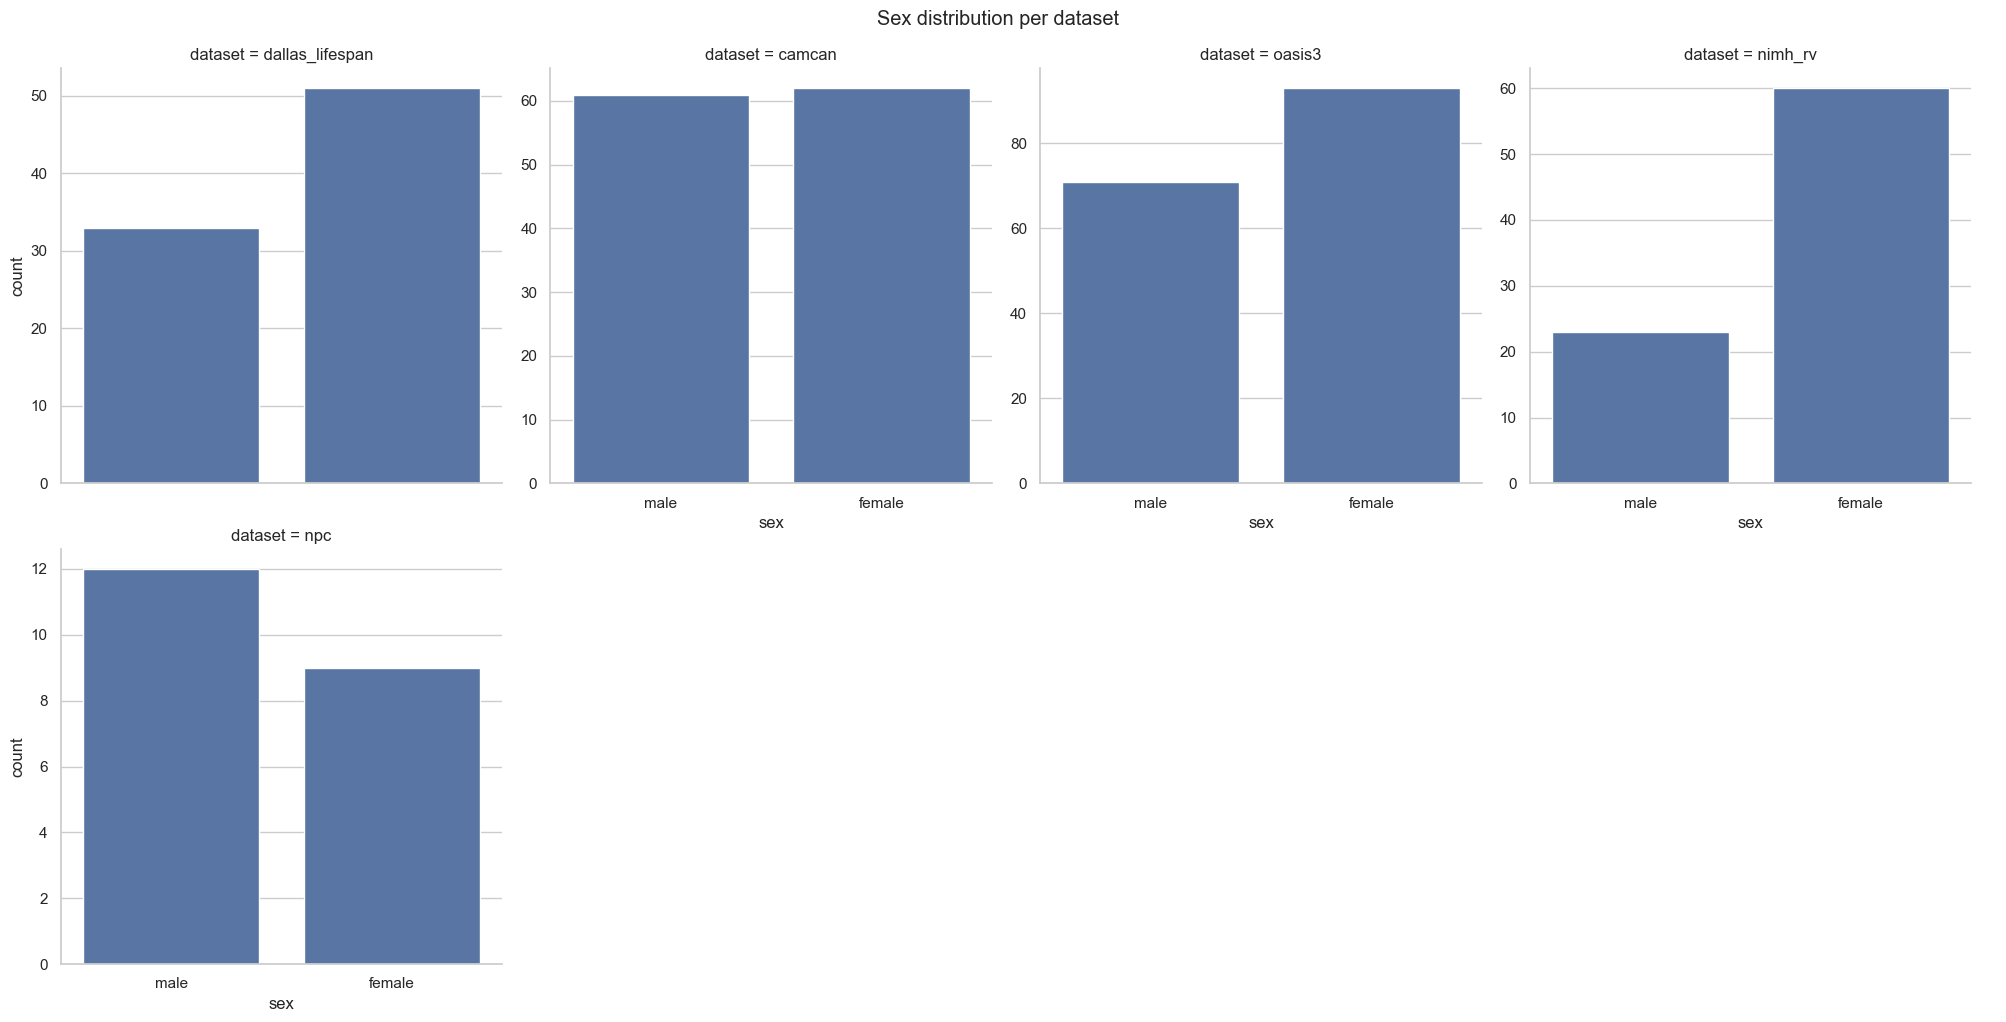

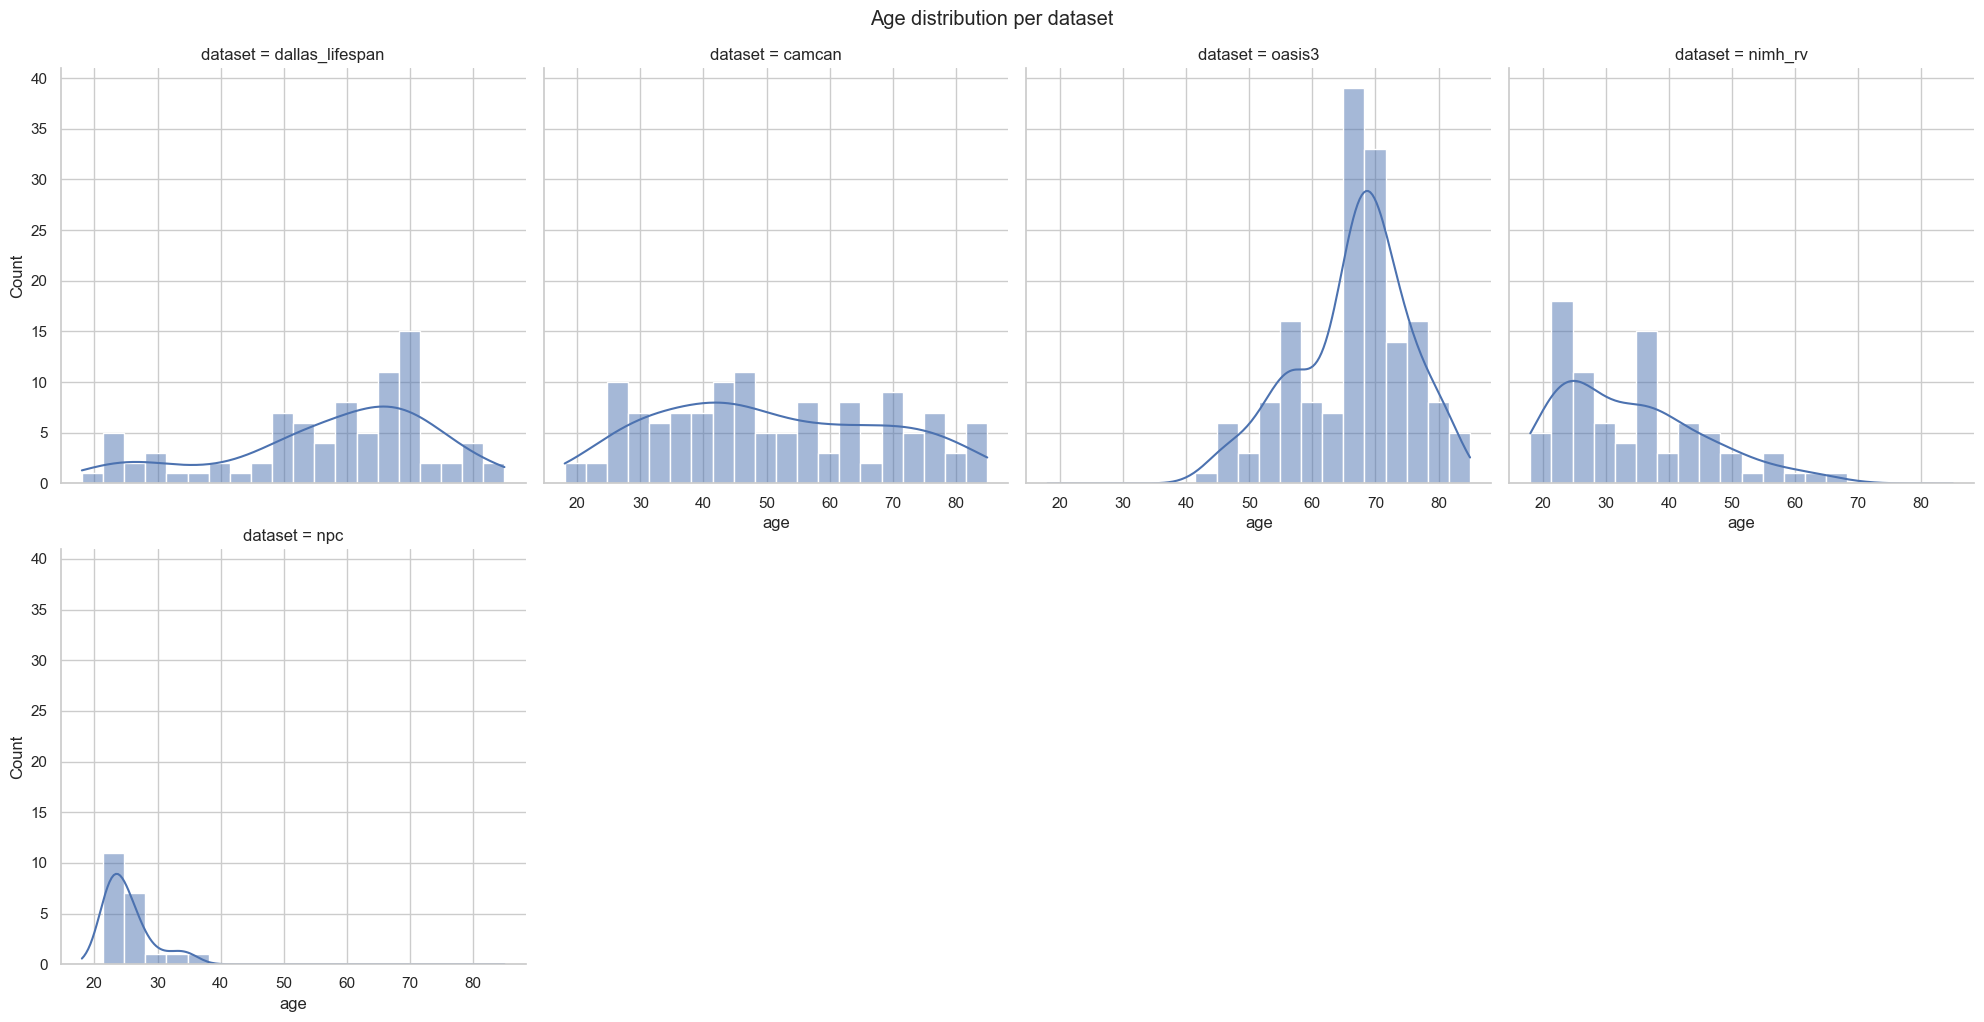

=== VAL coverage ===
Expected combinations : 408
Observed combinations : 245
Missing combinations  : 163



,age,sex,modality
0,18,female,flair
1,18,female,t1
2,18,female,t2
3,18,male,flair
4,18,male,t2
...,...,...,...
158,84,male,t2
159,85,female,flair
160,85,female,t1
161,85,female,t2


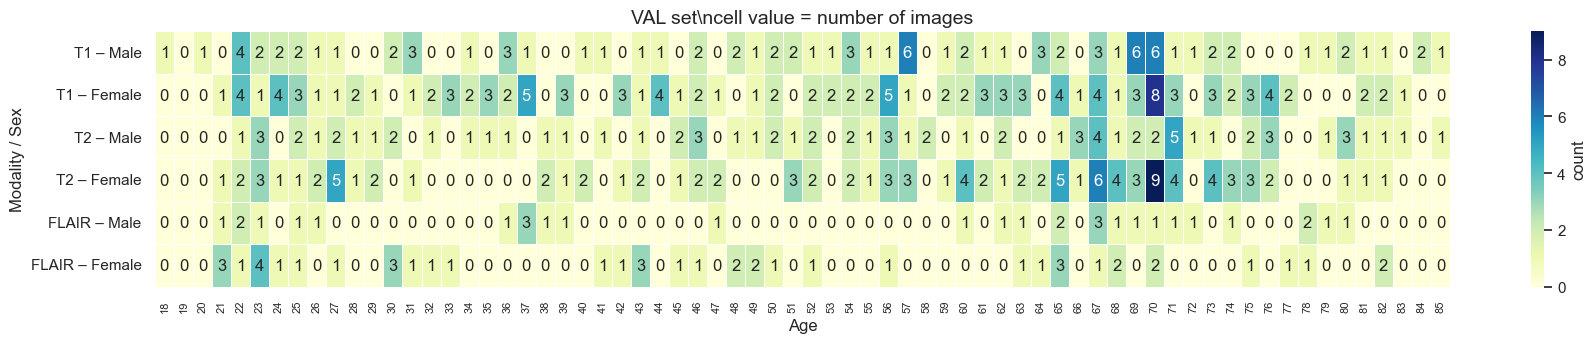

Saved val_one_per_combo.csv


In [320]:
if not df_val.empty:
    quick_plots(df_val, 'VAL set')
    val_subset = coverage_report(df_val, 'VAL coverage')
    val_subset.to_csv('val_one_per_combo.csv', index=False)
    plot_count_heatmap(df_val, 'VAL set')
    print('Saved val_one_per_combo.csv')
else:
    print('VAL set is empty – no analysis performed.')

### Test Set Analysis


### TEST set – shape: (314, 6)



,subject_id,image_path,sex,age,modality,dataset
1209,sub-001,/mnt/data/brain_age_preprocessed/OpenNeuro/Bol...,male,66,flair,boldvar
1210,sub-001,/mnt/data/brain_age_preprocessed/OpenNeuro/Bol...,male,66,t1,boldvar
1211,sub-002,/mnt/data/brain_age_preprocessed/OpenNeuro/Bol...,female,81,flair,boldvar
1212,sub-002,/mnt/data/brain_age_preprocessed/OpenNeuro/Bol...,female,81,t1,boldvar
1213,sub-003,/mnt/data/brain_age_preprocessed/OpenNeuro/Bol...,male,40,flair,boldvar


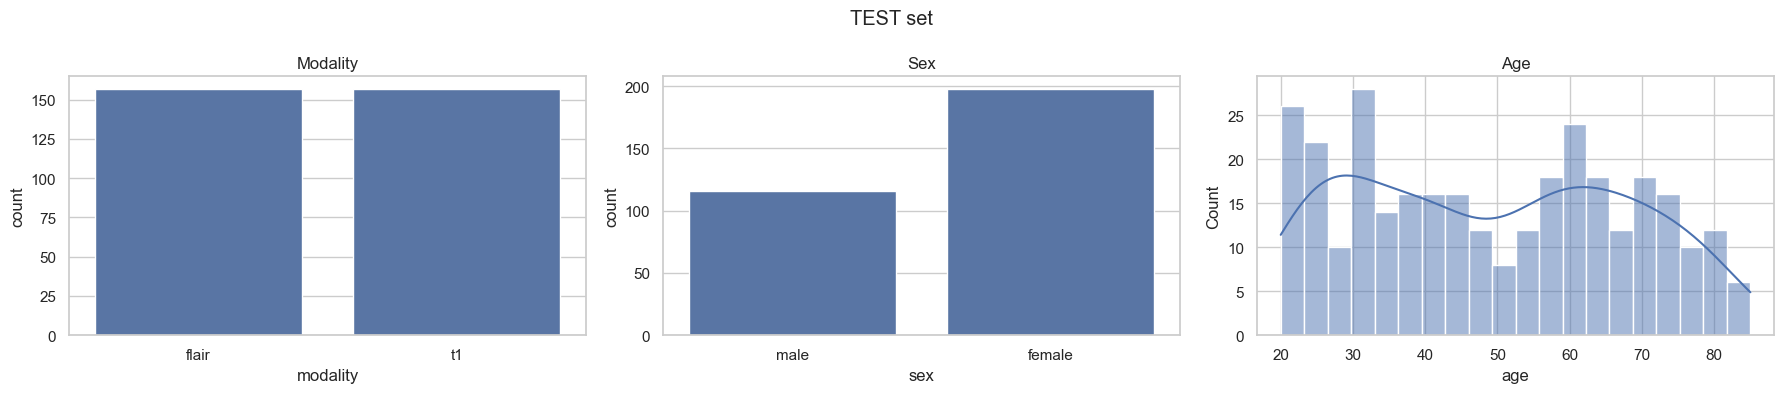

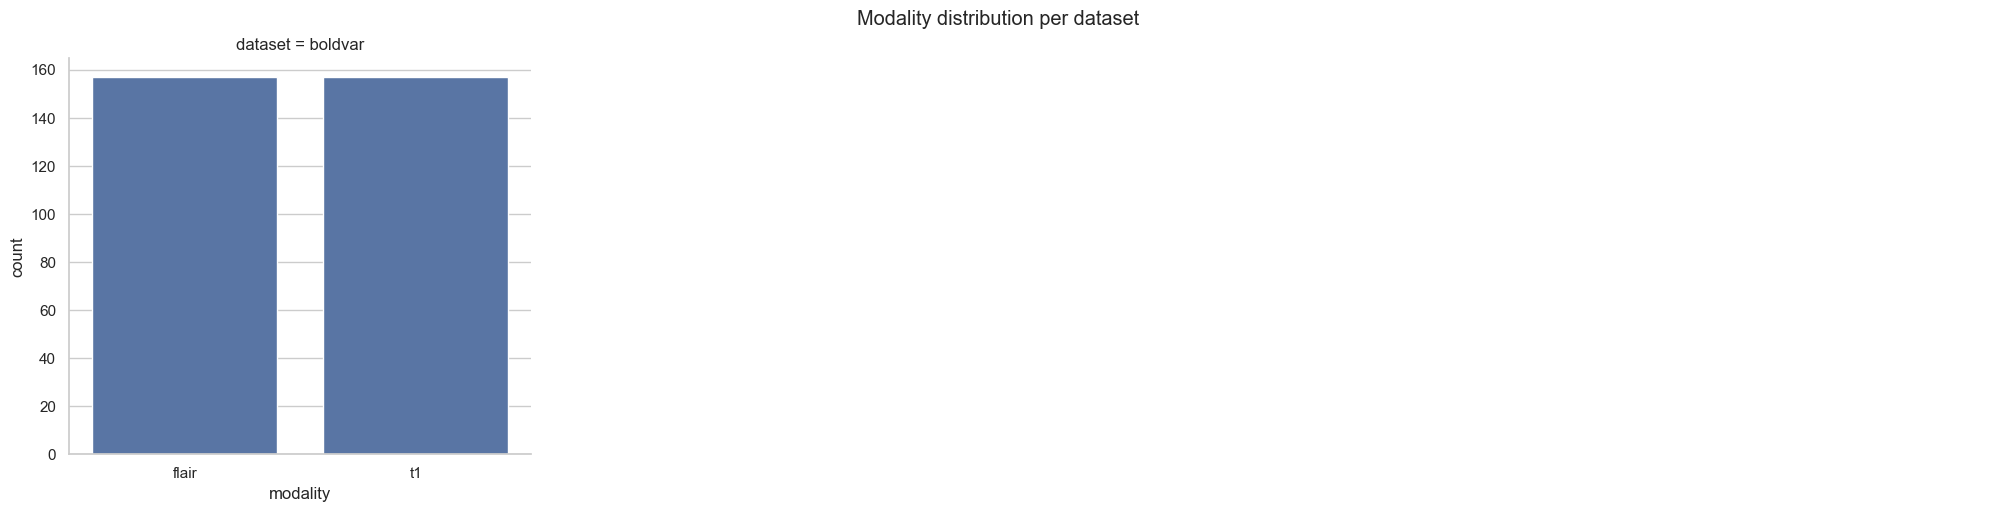

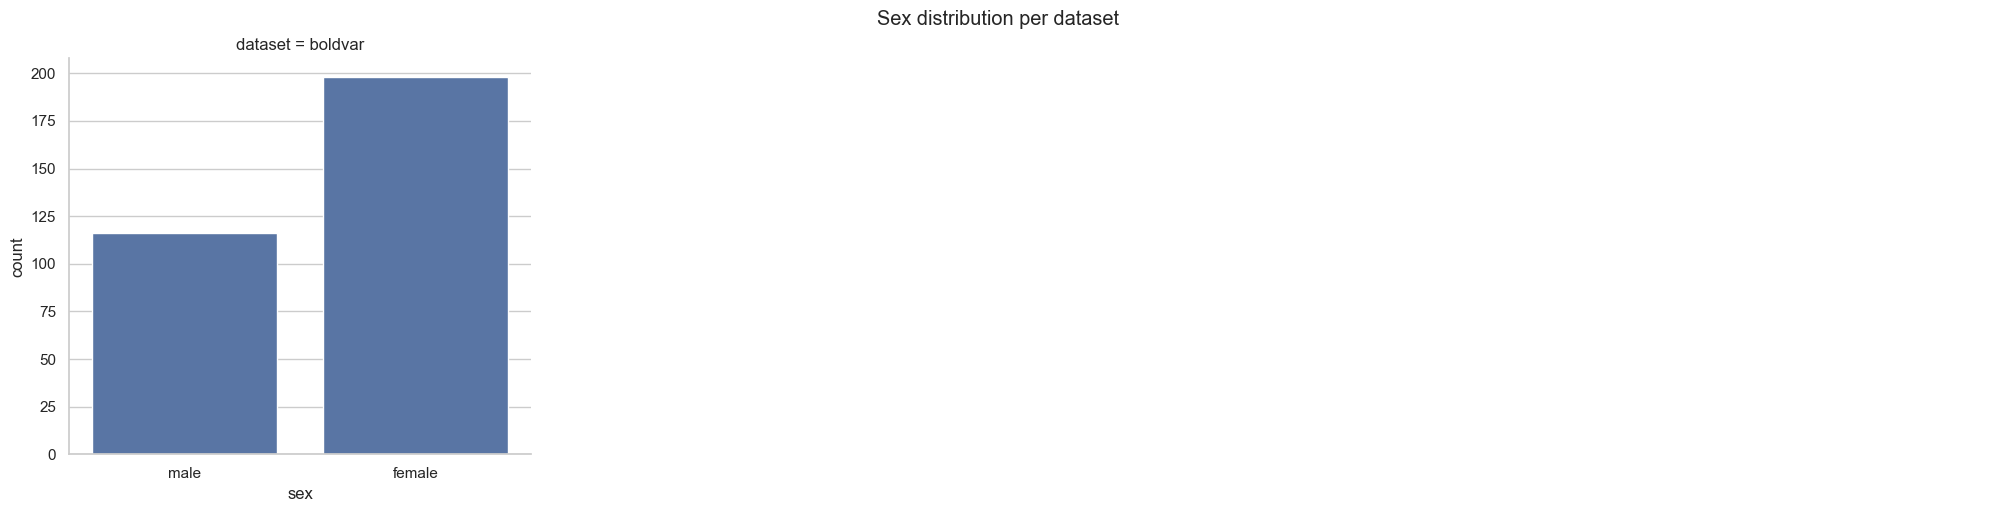

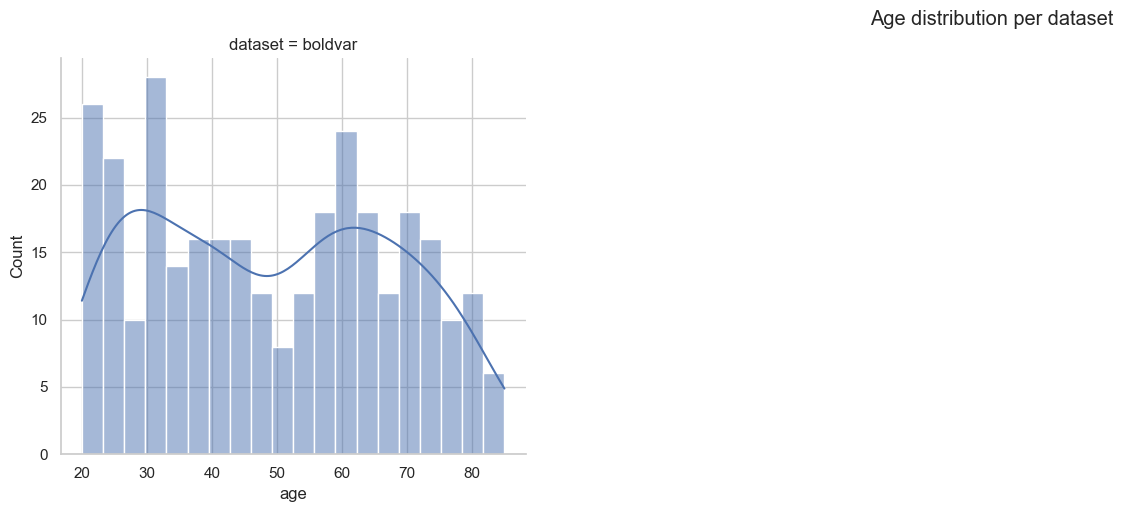

=== TEST coverage ===
Expected combinations : 408
Observed combinations : 176
Missing combinations  : 232



,age,sex,modality
0,18,female,flair
1,18,female,t1
2,18,female,t2
3,18,male,flair
4,18,male,t1
...,...,...,...
227,84,male,t2
228,85,female,t2
229,85,male,flair
230,85,male,t1


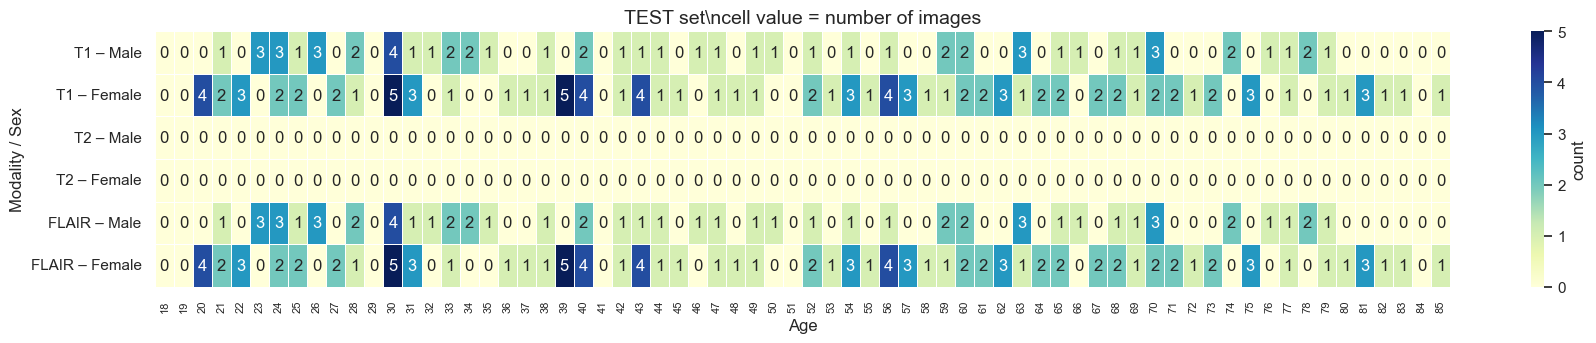

Saved test_one_per_combo.csv


In [321]:
quick_plots(df_test, 'TEST set')
test_subset = coverage_report(df_test, 'TEST coverage')
test_subset.to_csv('test_one_per_combo.csv', index=False)
plot_count_heatmap(df_test, 'TEST set')
print('Saved test_one_per_combo.csv')

### Full (Train + Val + Test) Dataset Analysis


### FULL dataset (used rows only) – shape: (5055, 6)



,subject_id,image_path,sex,age,modality,dataset
1209,sub-001,/mnt/data/brain_age_preprocessed/OpenNeuro/Bol...,male,66,flair,boldvar
1210,sub-001,/mnt/data/brain_age_preprocessed/OpenNeuro/Bol...,male,66,t1,boldvar
1211,sub-002,/mnt/data/brain_age_preprocessed/OpenNeuro/Bol...,female,81,flair,boldvar
1212,sub-002,/mnt/data/brain_age_preprocessed/OpenNeuro/Bol...,female,81,t1,boldvar
1213,sub-003,/mnt/data/brain_age_preprocessed/OpenNeuro/Bol...,male,40,flair,boldvar


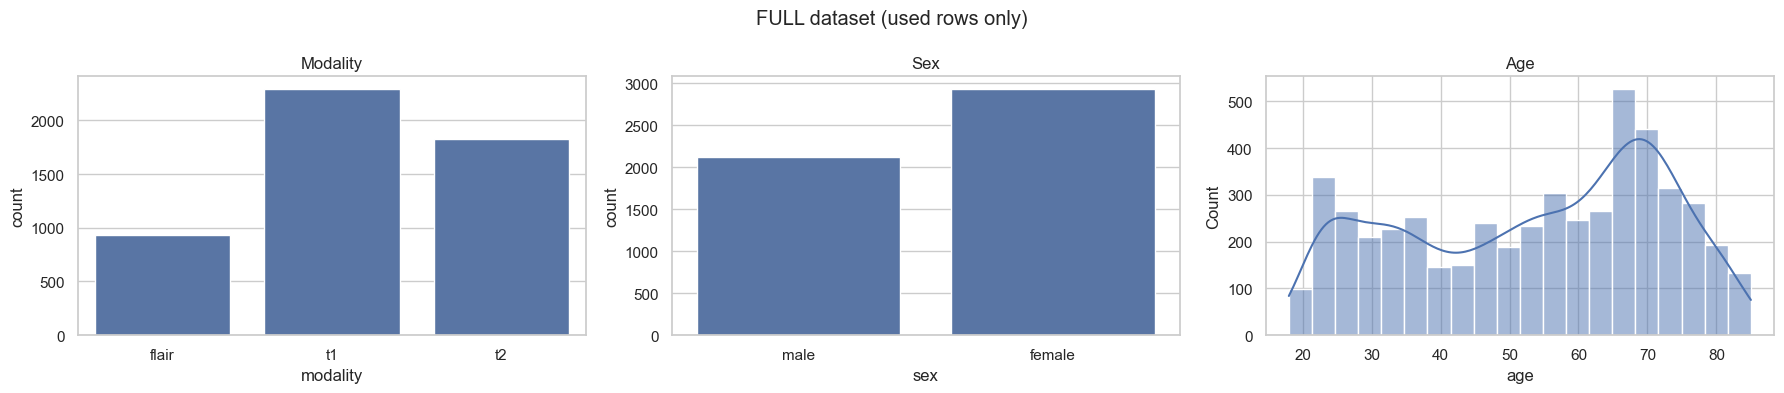

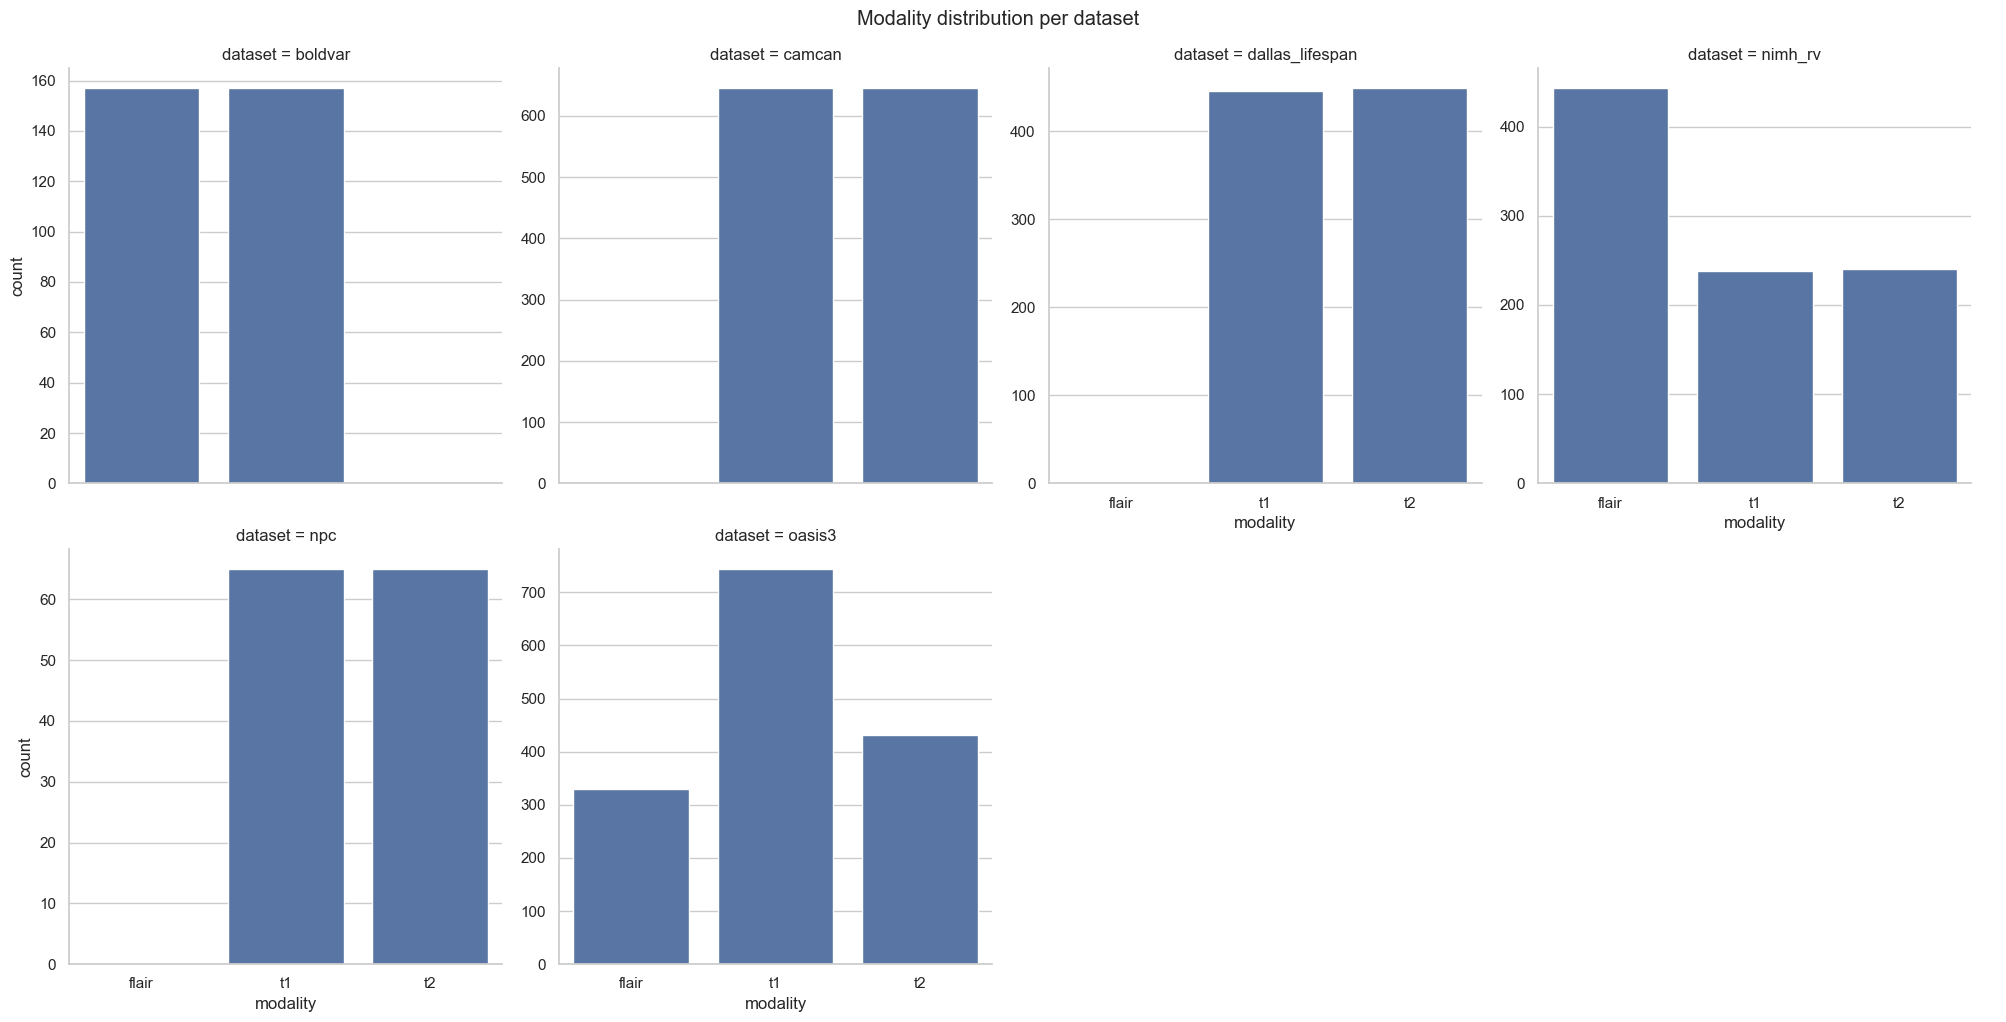

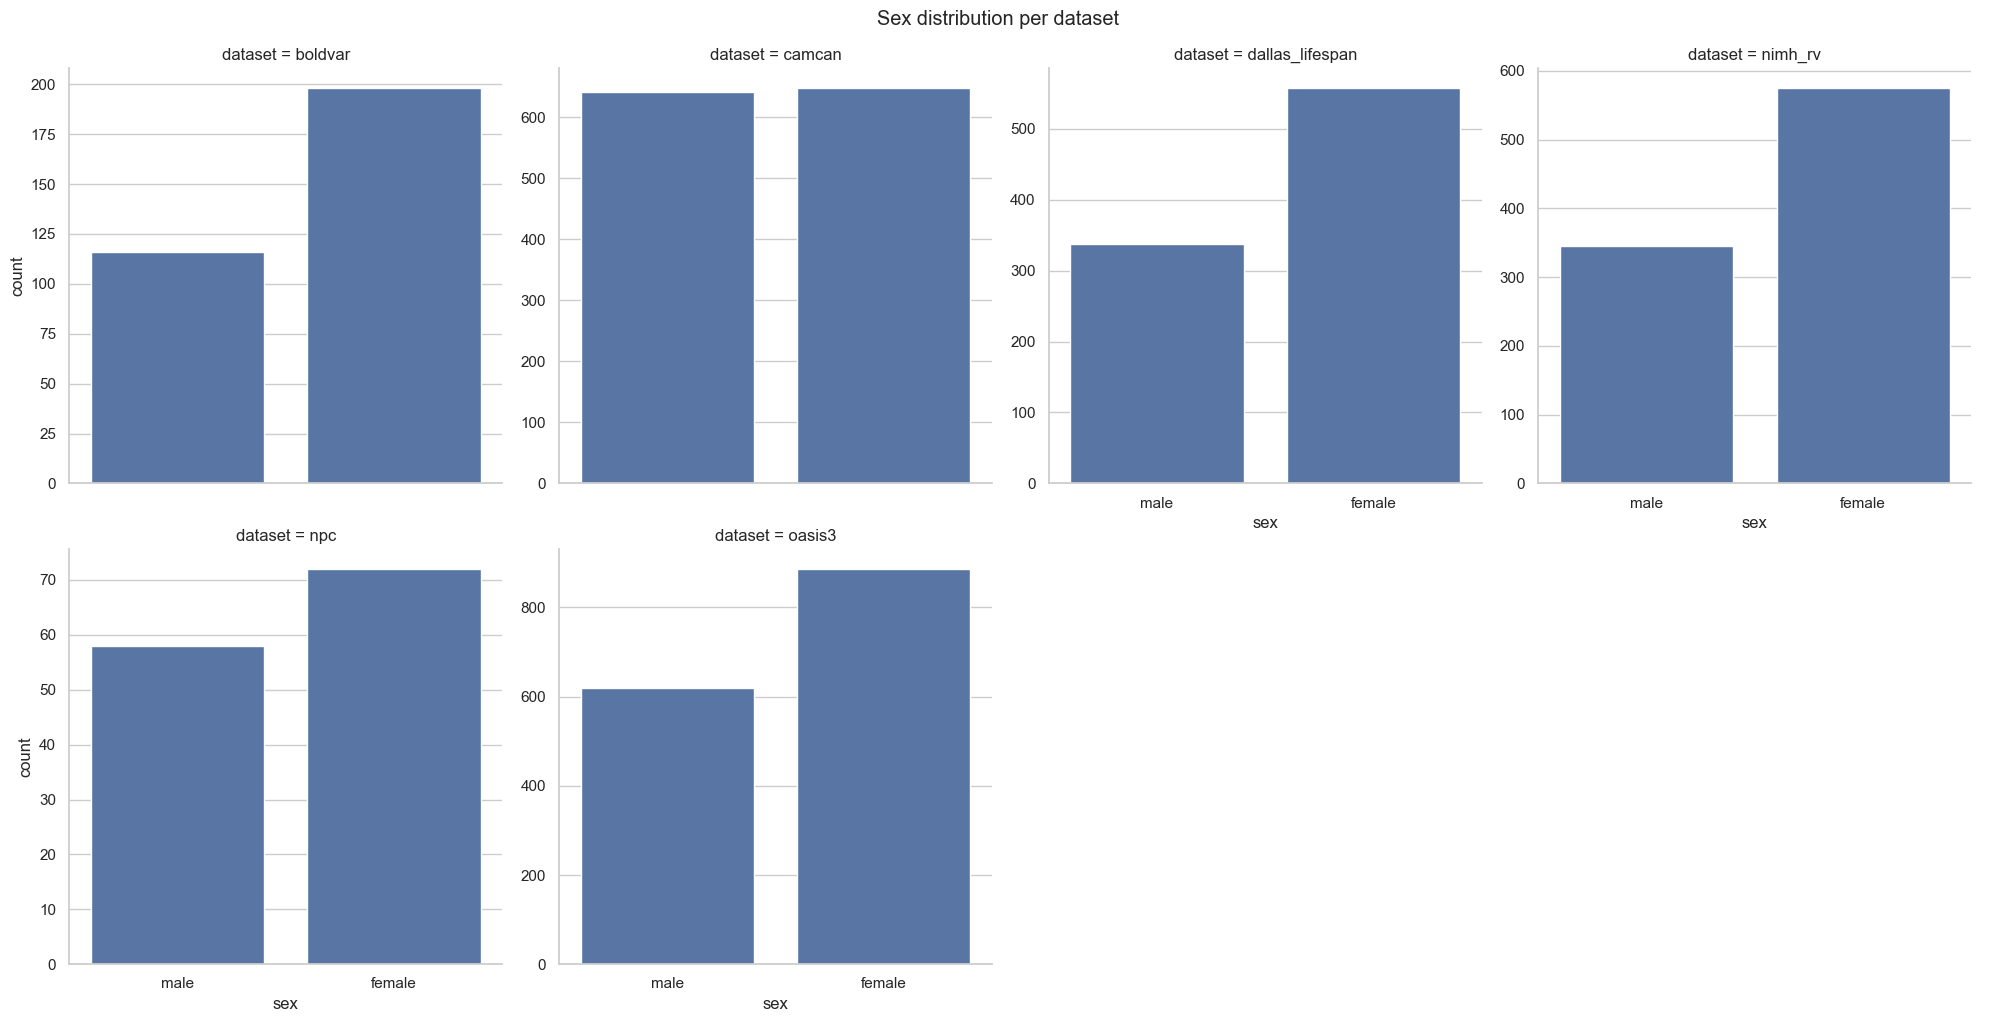

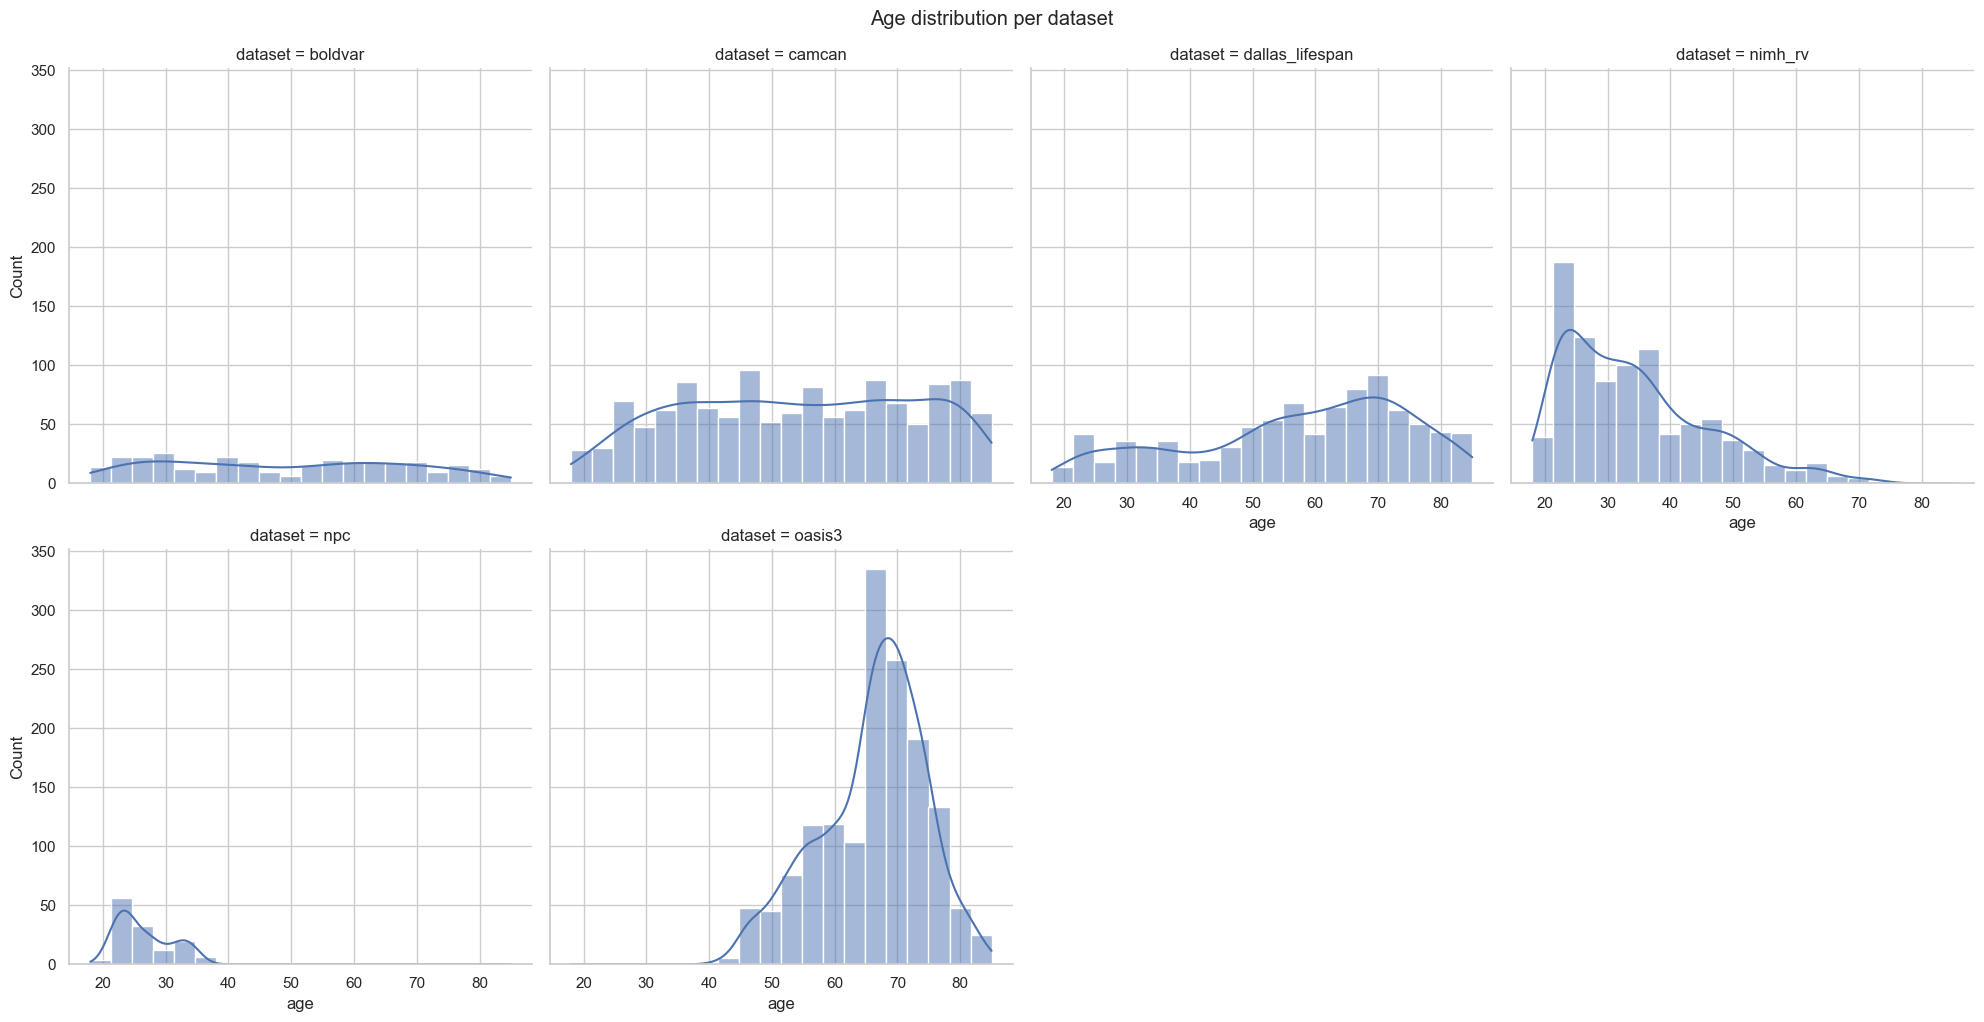

=== FULL coverage ===
Expected combinations : 408
Observed combinations : 398
Missing combinations  : 10



,age,sex,modality
0,18,female,flair
1,18,male,flair
2,19,female,flair
3,41,male,flair
4,45,male,flair
5,53,male,flair
6,82,male,flair
7,83,male,flair
8,84,female,flair
9,84,male,flair


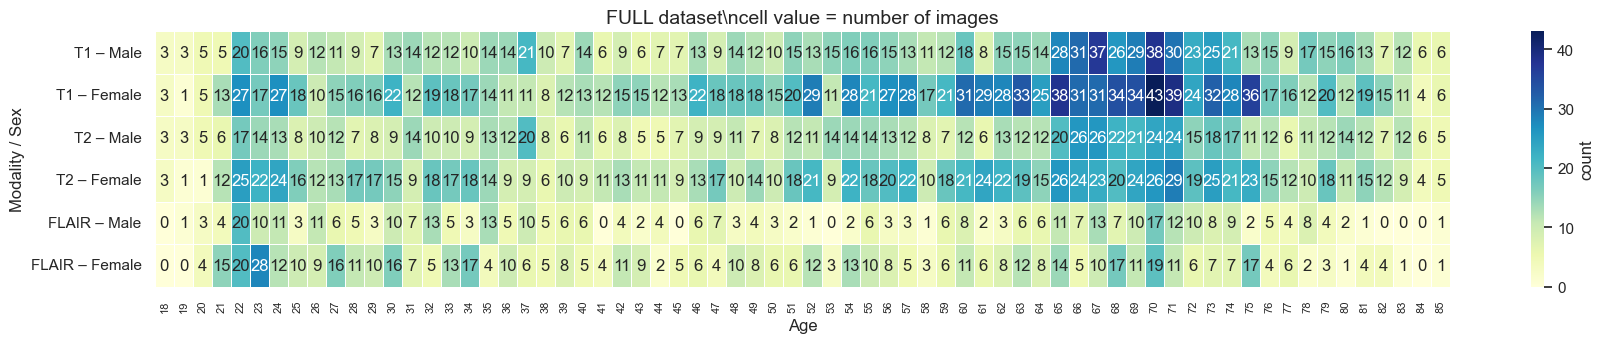

In [322]:
quick_plots(df_all, 'FULL dataset (used rows only)')
_ = coverage_report(df_all, 'FULL coverage')
plot_count_heatmap(df_all, 'FULL dataset')